In [31]:
import pandas as pd
import os, re
import csv

In [2]:
# Change the work directory to the parent
try:
    if chdir:
        pass
except:
    current_dir = os.getcwd()
    os.chdir(current_dir +"/..")
    os.path.abspath(os.curdir)

In [3]:
chdir = True

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [9]:
# Metadata for specific SFC configurations
exp_ls = "exp-51"
vnfs = ["firewall.csv", "nf_router.csv", "ndpi_stats.csv", "payload_scan.csv", "bridge.csv"]

In [10]:
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []

    if file.startswith("latency.csv"):
        with open(os.path.join(exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "intervention" else f.readlines()
            for line in lines:
                try:
                    value = float(line.strip()) / 1000
                except ValueError:
                    value = "N/A"
                tmp.append(value)
    else:
        with open(os.path.join(exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                try:
                    value = float(l.strip().split(",")[index])
                except ValueError:
                    value = "N/A"
                tmp.append(value)

    return tmp


In [11]:
def parse_reg(exp_type, exp_num, file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join(exp_type, exp_num, file)) as file:
        for line in file:
            if re.search(stat_name, line):
                try:
                    value = float(line.strip().split(',')[index])
                except ValueError:
                    value = "N/A"
                stat.append(value)

    return stat


In [21]:
latency = parse_seq("intervention", exp_ls, "latency.csv")
len(latency)

2010

In [13]:
tx_stats = parse_seq("intervention", exp_ls, "tx_stats.csv")
len(tx_stats)

2012

In [14]:
rx_stats = parse_seq("intervention", exp_ls, "rx_stats.csv")
len(rx_stats)

2012

In [15]:
firewall_instructions = parse_reg("intervention", exp_ls, "firewall.csv", "instructions", 1)
len(firewall_instructions)

2010

In [16]:
features = ["instructions", "branches,", "branch-misses,", "branch-load-misses,", "cache-misses", \
            "cache-references", ",cycles,", "L1-dcache-load-misses", "L1-dcache-loads", "LLC-load-misses", \
            "LLC-stores", "LLC-loads",]

In [17]:
def make_df():
    tmp = []
    dic = dict()
    
    tx_stats = parse_seq("intervention", exp_ls, "tx_stats.csv")
    rx_stats = parse_seq("intervention", exp_ls, "rx_stats.csv")
    
    latency = parse_seq("intervention", exp_ls, "latency.csv")
 
    
    seq_length = min([len(parse_reg("intervention", exp_ls, "firewall.csv", "instructions", 1)), \
                          len(tx_stats), \
                          len(rx_stats), \
                          len(latency)])
    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]
    
    for f in features:
        for v in vnfs:
            tmp = parse_reg("intervention", exp_ls, v, f, 1)
            
            dic[v.split(".")[0]+"_"+f.replace(",","")] = tmp[:seq_length]
            
    return pd.DataFrame(dic)

In [18]:
def make_df():
    tmp = []
    dic = dict()
    
    tx_stats = parse_seq("intervention", exp_ls, "tx_stats.csv")
    rx_stats = parse_seq("intervention", exp_ls, "rx_stats.csv")
    latency = parse_seq("intervention", exp_ls, "latency.csv")

    seq_length = min(len(parse_reg("intervention", exp_ls, "firewall.csv", "instructions", 1)), len(tx_stats), len(rx_stats), len(latency))
    
    # Get data for each feature and VNF
    for f in features:
        for v in vnfs:
            tmp = parse_reg("intervention", exp_ls, v, f, 1)
            if len(tmp) < seq_length:
                tmp += ["N/A"] * (seq_length - len(tmp))  # Add "N/A" values if list is too short
            dic[v.split(".")[0] + "_" + f.replace(",", "")] = tmp[:seq_length]

    # Add remaining data to dictionary
    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]
    
    return pd.DataFrame(dic)


In [19]:
df = make_df()

In [20]:
import os

# Specify the folder path
folder_path = "../linear/intervention"

# Combine the folder path with the file name
file_path = os.path.join(folder_path, exp_ls + ".csv")

# Save the DataFrame as a CSV file in the specified folder
df.to_csv(file_path, sep=',')


In [163]:
# delete N/A, and delete the first column
import pandas as pd

def process_csv(input_file, output_file, fixed_input_rate):
    # Read CSV file into a DataFrame
    df = pd.read_csv(input_file)
    
    # Drop the first column
    df = df.drop(df.columns[0], axis=1)
    
    # Drop the first two rows
    df = df.iloc[2:]
    
    # Drop the last row
    df = df.iloc[:-1]
    
    # Set the "input_rate" column to a fixed value
    df.loc[:, "input_rate"] = fixed_input_rate
    
    # Write the processed DataFrame to a new CSV file
    df.to_csv(output_file, index=False)
   
    
    
process_csv("load_stimulus_fixed_rate_7500.csv", "load_stimulus_fixed_rate_7500_modified.csv", 5250)

C:\Users\Qiong\AppData\Local\Temp\ipykernel_11756\3264640588.py:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "input_rate"] = fixed_input_rate


<Axes: >

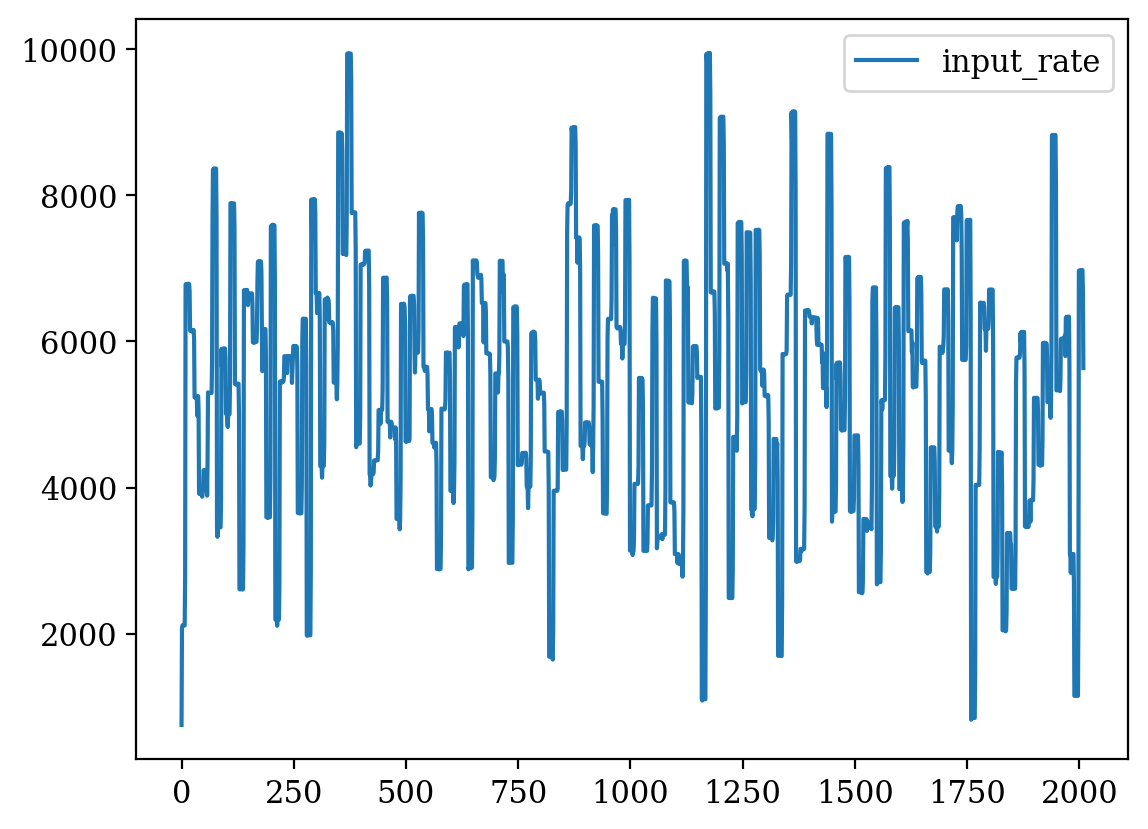

In [164]:
df[["input_rate"]].plot()